In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os
os.environ['KERAS_BACKEND'] = 'torch'
import keras_core as keras
from models.analytical.trapdiffusion import SingleOccupationSingleIsotope
import matplotlib.pyplot as plt
import inference

Using PyTorch backend.


In [13]:
basic_model = keras.models.load_model('trained_models/basic.keras')
weights = []
weightsT = []
biases = []
for layer in basic_model.layers:
    weights.append(layer.get_weights()[0])
    weightsT.append(np.ascontiguousarray(layer.get_weights()[0].T))
    biases.append(layer.get_weights()[1])

def predict_gpu(weights, biases, x):
    return basic_model.predict(x)

def predict(weights, biases, x):
    for layer, bias in zip(weights, biases):
        x = x @ layer + bias
        x[x < 0] = 0
    return x

def predict_cpp(weightsT, biases, x):
    for layer, bias in zip(weightsT, biases):
        x = inference.affine_batched(layer, bias,x)
        x = inference.relu(x)
    return x

def validation_plot(prediction_function, weights, biases, seed = None):
    np.random.seed(seed)
    analytical_model = SingleOccupationSingleIsotope(2,1)
    c_init = analytical_model.initial_values()
    ts, cs = analytical_model.solve(c_init,50)
    inputs = np.repeat([c_init],len(ts),axis=0)
    inputs = np.append(ts.reshape(-1,1),inputs,axis=1)
    predictions = prediction_function(weights, biases, inputs)
    delta = np.abs(cs-predictions.T)
    max_delta = np.max(delta)
    colors = []
    for c in cs:
        p = plt.plot(ts,c,label= "Analytical", linestyle = "--", linewidth = 2)
        colors.append(p[0].get_color())
    for color, prediction in zip(colors,predictions.T):
        plt.plot(ts,prediction, label=prediction_function.__name__, color=color)
    plt.ylabel("Concentration")
    plt.xlabel("Time")
    plt.title(f"Small Model, Fixed Transition Rates\nmax error: {max_delta:.2e}")
    plt.legend()
    plt.grid()

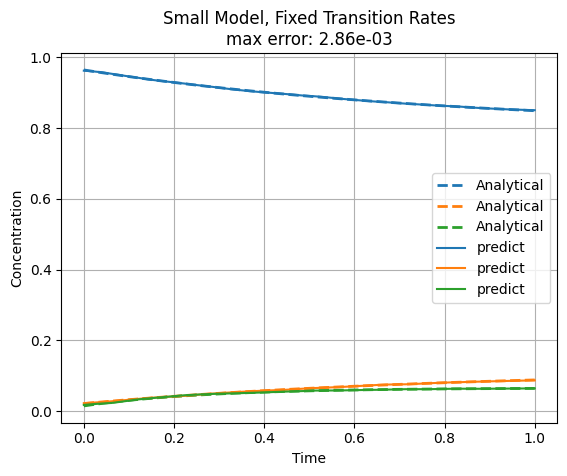

In [7]:
validation_plot(predict, weights, biases, seed = 1)

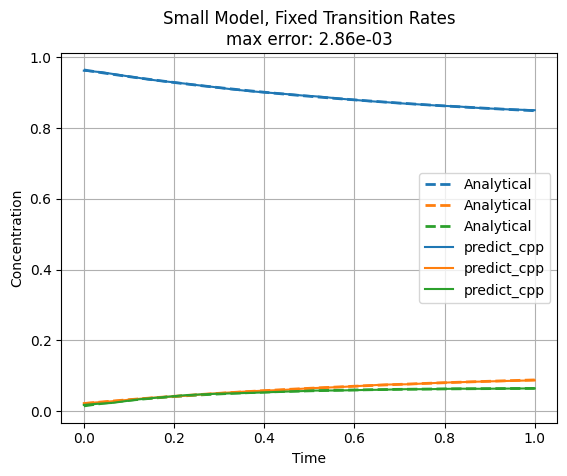

In [8]:
validation_plot(predict_cpp, weightsT, biases, seed = 1)

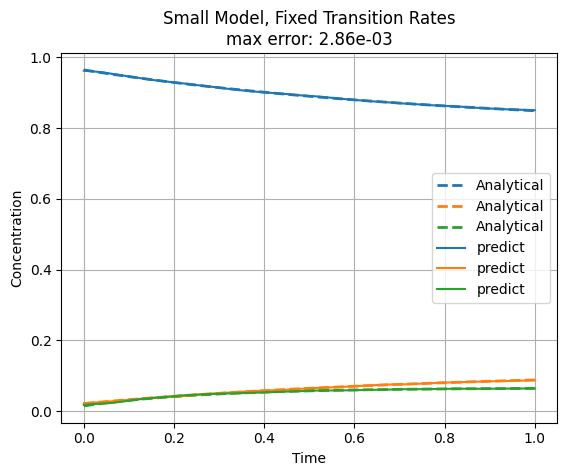

In [10]:
validation_plot(inference.predict, weightsT, biases, seed = 1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 0s/step


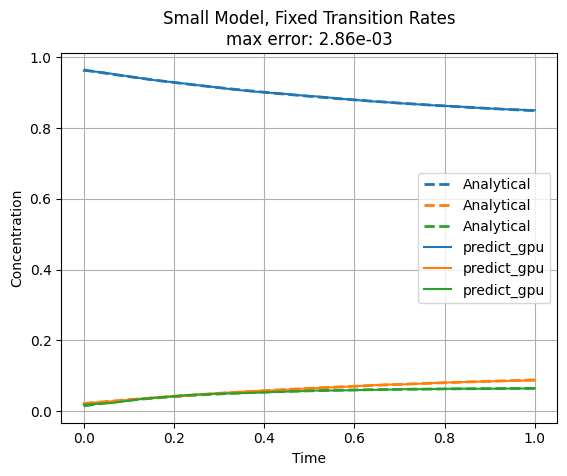

In [14]:
validation_plot(predict_gpu, weights, biases, seed = 1)